**Случайные процессы, прикладной поток. Семинар 1.**

**Анастасия Ремизова**

# Проверка статистических гипотез в Python

In [3]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.neighbors import KernelDensity as KDE
from statsmodels.sandbox.stats.multicomp import multipletests

%matplotlib inline

**Критерий согласия хи-квадрат**

<a href=https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html#scipy.stats.chisquare>`scipy.stats.chisquare`</a>`(f_obs, f_exp=None, ddof=0)`

`f_obs` --- число элементов выборки, попавших в каждый из интервалов

`f_exp` --- ожидаемое число элементов выборки (по умолчанию равномерное)

`ddof` --- поправка на число степеней свободы. Статистика асимптотически будет иметь распределение хи-квадрат с числом степеней свободы $k - 1 - ddof$, где $k$ --- число интервалов.

Возвращает значение статистики критерия и соответствующее p-value.

**Критерий согласия Колмогорова**

<a href=https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html#scipy.stats.kstest>`scipy.stats.kstest`</a>`(rvs, cdf, args=())`

`rvs` --- выборка

`cdf` --- функция распределения (сама функция или ее название)

`args` --- параметры распределения

Возвращает значение статистики критерия и соответствующее p-value.

**Критерий проверки нормальности Шапиро-Уилка**

<a href=https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html>`scipy.stats.shapiro`</a>`(x, a=None, reta=False)`

`x` --- выборка

### Критерий согласия Колмогорова, хи-квадрат и Шапиро-Уилка для проверки распределения на нормальность

Вспомогательная функция для построения графика:

In [2]:
def norm_plot(x, bins=10, bandwidth=1):
    plt.figure(figsize=(10, 6))
    plt.hist(x, label="hist", bins=bins, normed=True, color='turquoise')

    xmin, xmax = plt.xlim()
    x_axis = np.linspace(xmin, xmax, 300)

    n_params = sps.norm.fit(x)
    plt.plot(x_axis,
             sps.norm.pdf(x_axis, loc=n_params[0], scale=n_params[1]),
             label="norm_pdf")

    kernel_density = KDE(bandwidth=bandwidth).fit(x[:, np.newaxis])
    plt.plot(x_axis, np.exp(kernel_density.score_samples(x_axis[:, np.newaxis])), label='kde')

    plt.legend()
    plt.show()

Вспомогательная функция для проверки на нормальность. Критерий Колмогорова применяется для нормального распределения, у которого параметры &mdash; ОМП.

In [99]:
def check_norm(x, bins=10, alpha=0.05):    
    print("Гипотеза: распределение нормальное.\n")
    
    shtest = sps.shapiro(x)
    print("Статистика критерия Шапиро-Уилка:", round(shtest[0], 5))
    print("p-value: ", round(shtest[1], 5))
    if shtest[1] < alpha:
        print("Гипотеза отвергается.\n")
    else:
        print("Гипотеза не отвергается.\n")

    n_params = sps.norm.fit(x)  # ОМП для нормального распределения
    norm = sps.norm(loc=n_params[0], scale=n_params[1])
    
    kstest = sps.kstest(x, 'norm', args=n_params)
    print("Статистика критерия Колмогорова:", round(kstest.statistic, 5))
    print("p-value: ", round(kstest.pvalue, 5))
    if kstest.pvalue < alpha:
        print("Гипотеза отвергается.\n")
    else:
        print("Гипотеза не отвергается.\n")
    
    # Вспомогательная функция, подсчитывающая число элементов выборки,
    # лежащих в подмножествах разбиения.
    def count_data(x, delim):
        res = []
        res.append((x < delim[0]).sum())
        for i in range(1, len(delim)):
            res.append(((delim[i-1] <= x) & (x < delim[i])).sum())
        res.append((delim[-1] <= x).sum())
        return res
    
    # Критерий хи-квадрат.
    if len(x) < 50:
        return
    
    if 5 > float(len(x)) / bins:
        bins = int(len(x) / 5)
    
    # Разбиение на интервалы, равные по вероятностной мере.
    f_exp = np.ones(bins, dtype=np.float64) / bins
    delim = list(map(lambda y: norm.ppf(y), f_exp.cumsum()))
    delim = delim[:-1]
    ctest = sps.chisquare(count_data(x, delim), f_exp=f_exp * len(x))
    print ("Статистика критерия хи-квадрат при разбиении на интервалы, "\
           "равные по вероятностной мере:",
           round(ctest.statistic, 5))
    print ("p-value: ", round(ctest.pvalue, 5))
    if ctest.pvalue < alpha:
        print ("Гипотеза отвергается.\n")
    else:
        print ("Гипотеза не отвергается.\n")

<a href=http://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html>Различные датасеты</a>

In [23]:
psych_data = pd.read_csv("x07.txt", delim_whitespace=True)
print("Размер выборки:", len(psych_data))
psych_data.head()

Размер выборки: 53


,Index,RetardationIndex,DistrustIndex,DegreeOfIllnessAfter6Months
0,1,2.80,6.1,44
1,2,3.10,5.1,25
2,3,2.59,6.0,10
3,4,3.36,6.9,28
4,5,2.80,7.0,25


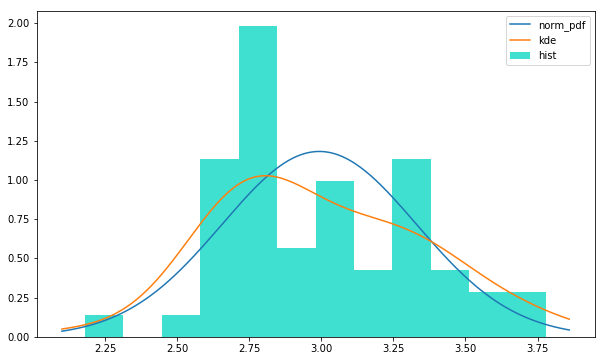

Гипотеза: распределение нормальное.

Статистика критерия Шапиро-Уилка: 0.96178
p-value:  0.08797
Гипотеза не отвергается.

Статистика критерия Колмогорова: 0.15884
p-value:  0.12351
Гипотеза не отвергается.

Статистика критерия хи-квадрат при разбиении на интервалы, равные по вероятностной мере: 22.66038
p-value:  0.00701
Гипотеза отвергается.



In [100]:
x = psych_data.values[:, 1]
norm_plot(x, bins=12, bandwidth=0.2)
check_norm(x)

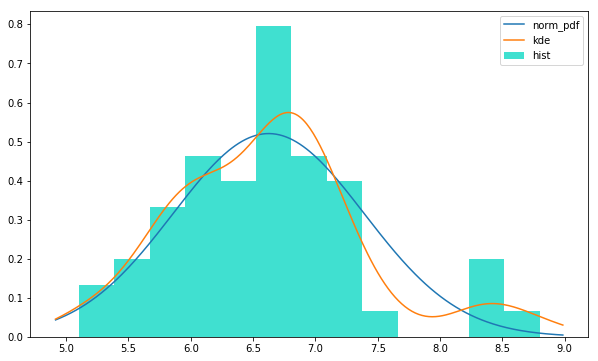

Гипотеза: распределение нормальное.

Статистика критерия Шапиро-Уилка: 0.95222
p-value:  0.03355
Гипотеза отвергается.

Статистика критерия Колмогорова: 0.11437
p-value:  0.46398
Гипотеза не отвергается.

Статистика критерия хи-квадрат при разбиении на интервалы, равные по вероятностной мере: 7.56604
p-value:  0.5784
Гипотеза не отвергается.



In [101]:
x = psych_data.values[:, 2]
norm_plot(x, bins=13, bandwidth=0.3)
check_norm(x)

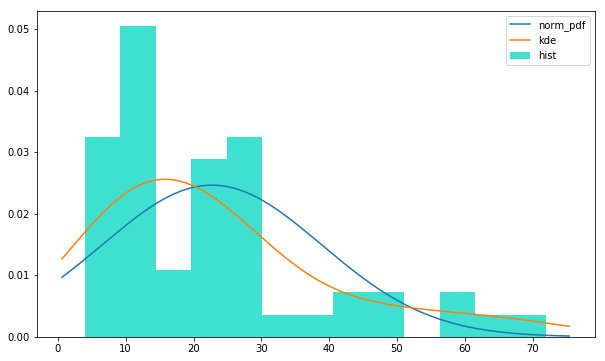

Гипотеза: распределение нормальное.

Статистика критерия Шапиро-Уилка: 0.84579
p-value:  1e-05
Гипотеза отвергается.

Статистика критерия Колмогорова: 0.18335
p-value:  0.04953
Гипотеза отвергается.

Статистика критерия хи-квадрат при разбиении на интервалы, равные по вероятностной мере: 34.73585
p-value:  7e-05
Гипотеза отвергается.



In [102]:
x = psych_data.values[:, 3]
norm_plot(x, bins=13, bandwidth=10)
check_norm(x)

Можно сделать вывод (в частности, из второго примера), что критерий Шапиро-Уилка более мощный, чем критерий Колмогорова.

Заметим, что если мы используем все рассматриваемые критерии для каждой соответствующей гипотезы, то мы не можем отклонять все гипотезы с pvalue < уровня значимости. Об этом речь пойдет позднее.

### Критерий согласия Колмогорова для выборки из гамма-распределения

Следующий датасет &mdash; <a href=https://archive.ics.uci.edu/ml/datasets/Air+Quality>`Air Quality Data Set`</a> &mdash; содержит усредненные за час результаты измерения характеристик воздуха, таких, как содержание различных элементов, температуру и влажность.

In [22]:
air_data = pd.read_csv("AirQualityUCI.csv", sep=";", decimal=",")
air_data = air_data.drop(air_data.columns[[15, 16]], axis=1)
air_data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


Анализируем данные в столбце CO(GT) (средняя концентрация CO в мг/м^3). Подготовим данные &mdash; удалим отрицательные значения и NaN, так как они свидетельствуют о некорректности измерения.

In [70]:
x = air_data.values[:, 2]
x = x[pd.isnull(np.array(x, dtype=float)) == False]
x = x[x>=0]
x = x.astype(np.float64)

Вычислим параметры ОМП.

In [73]:
n_params = sps.norm.fit(x)
g_params = sps.gamma.fit(x)

Построим графики.

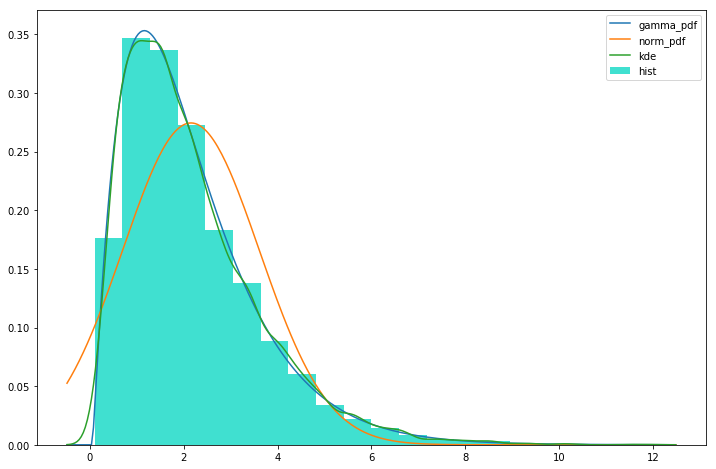

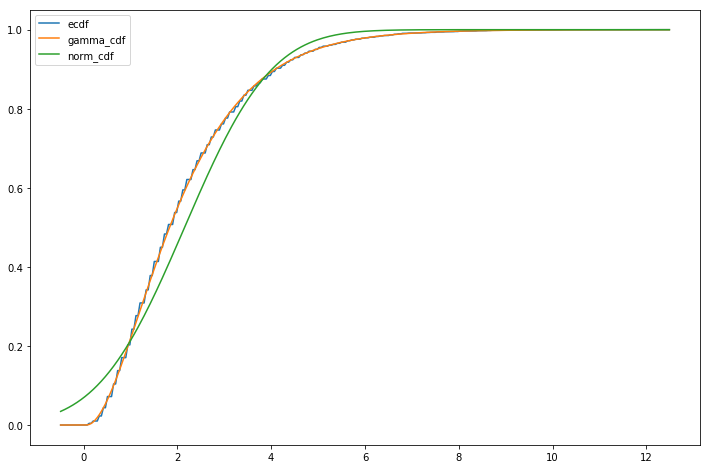

In [98]:
# График hist, kde, norm/gamma pdf.
plt.figure(figsize=(12, 8))
plt.hist(x, label="hist", bins=20, normed=True, color='turquoise')

xmin, xmax = plt.xlim()
x_axis = np.linspace(xmin, xmax, 300)

plt.plot(x_axis,
         sps.gamma.pdf(x_axis, g_params[0], loc=g_params[1], scale=g_params[2]),
         label="gamma_pdf")
plt.plot(x_axis,
         sps.norm.pdf(x_axis, loc=n_params[0], scale=n_params[1]),
         label="norm_pdf")

kernel_density = KDE(bandwidth=0.2).fit(x[:, np.newaxis])
plt.plot(x_axis, np.exp(kernel_density.score_samples(x_axis[:, np.newaxis])), label='kde')

plt.legend()
plt.show()

# График ecdf, norm/gamma cdf.
plt.figure(figsize=(12, 8))

plt.plot(x_axis, ECDF(x)(x_axis), label='ecdf')
plt.plot(x_axis,
         sps.gamma.cdf(x_axis, g_params[0], loc=g_params[1], scale=g_params[2]),
         label="gamma_сdf")
plt.plot(x_axis,
         sps.norm.cdf(x_axis, loc=n_params[0], scale=n_params[1]),
         label="norm_сdf")
plt.legend()
plt.show()

Можно увидеть, что распределение очень похоже на гамма-распределение, а вот на нормальное &mdash; совсем нет.
Убедимся, что выборка не подчиняется нормальному распределению, используя критерии Колмогорова (параметры распределения - ОМП) и Шапиро-Уилка.

In [104]:
def check_norm_gamma(x, alpha=0.05):
    shtest = sps.shapiro(x)
    print ("Гипотеза: распределение нормальное.")
    print ("Статистика критерия Шапиро-Уилка:", round(shtest[0], 3))
    print ("p-value: ", round(shtest[1], 3))
    if shtest[1] < alpha:
        print ("Гипотеза отвергается.\n")
    else:
        print ("Гипотеза не отвергается.\n")

    n_params = sps.norm.fit(x)
    g_params = sps.gamma.fit(x)
    for dist, params, label in [('norm', n_params, 'нормальное'),
                                ('gamma', g_params, 'гамма')]:
        print ("Гипотеза: распределение {0}.".format(label))
        kstest = sps.kstest(x, dist, args=params)
        print ("Статистика критерия Колмогорова:", round(kstest.statistic, 3))
        print ("p-value: ", round(kstest.pvalue, 3))
        if kstest.pvalue < alpha:
            print ("Гипотеза отвергается.\n")
        else:
            print ("Гипотеза не отвергается.\n")

In [105]:
check_norm_gamma(x)

Гипотеза: распределение нормальное.
Статистика критерия Шапиро-Уилка: 0.901
p-value:  0.0
Гипотеза отвергается.

Гипотеза: распределение нормальное.
Статистика критерия Колмогорова: 0.109
p-value:  0.0
Гипотеза отвергается.

Гипотеза: распределение гамма.
Статистика критерия Колмогорова: 0.024
p-value:  0.0
Гипотеза отвергается.



/home/feathernox/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1326: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Однако такое может происходить и потому, что выборка слишком велика (о чем нам говорит предупреждение). Возьмем подвыборку меньшего размера, причем с повторениями. Повторения необходимы, иначе свойства выборки нарушатся (поскольку мы не можем выбрать второй раз элемент, который уже был в выборке). Фактически, мы генерируем выборку из распределения с эмпирической функцией распределения, построенной по исходной выборке. На практике, берем выборку из дискретного равномерного распределения $\{0, 1, ..., n-1\}$, где $n$ равно размеру исходной выборки и выбираем элементы, соответствующие данным индексам в исходной.

In [129]:
sub_x = x[sps.randint.rvs(0, len(x), size=200)]
check_norm_gamma(sub_x)

Гипотеза: распределение нормальное.
Статистика критерия Шапиро-Уилка: 0.905
p-value:  0.0
Гипотеза отвергается.

Гипотеза: распределение нормальное.
Статистика критерия Колмогорова: 0.129
p-value:  0.002
Гипотеза отвергается.

Гипотеза: распределение гамма.
Статистика критерия Колмогорова: 0.052
p-value:  0.643
Гипотеза не отвергается.



Заметим, что нормальность распределения была отклонена, а вот принадлежность к гамма-распределению &mdash; нет.

### Множественная проверка гипотез

<a href=http://www.statsmodels.org/dev/generated/statsmodels.sandbox.stats.multicomp.multipletests.html>`statsmodels.sandbox.stats.multicomp.multipletests`</a>`(pvals, alpha=0.05, method='hs', is_sorted=False, returnsorted=False)`

`pvals` --- набор p-value

`alpha` --- желаемый общий уровень значимости

`method` --- метод (использовать 'bonferroni', если не знаете про другие)

`is_sorted` --- если true, то `pvals` должны быть уже отсортированы

-----

Возвращает: `reject, pvals_corrected, alphacSidak, alphacBonf`

`reject` --- отвергаемые гипотезы

`pvals_corrected` --- корректировка p-value. Смысл - их можно сравнивать непосредственно с `alpha`.

**Задача (№1 из задания 11 по матстатистике):** Пусть имеется $k$ выборок $X_j$
, для каждой из которых проверяется основная гипотеза $H_j$. Как
выборки, так и гипотезы могут совпадать, но все критерии различны. Считается, что происходит ошибка I рода, если отвергнута хотя бы одна верная гипотеза. Получились следующие
значения p-value: 0, 0.001, 0.01, 0.03, 0.04, 0.049, 0.1, 0.3, 1. Можно ли на уровне значимости
0.05 отвергнуть все гипотезы, у которых p-value меньше 0.05? Предложите способ решения
проблемы.

**Ответ:** нет; пусть:

- $\{X^i_j\}_{ij}$ &mdash; все данные;
- $S_j$ &mdash; критерий проверки гипотезы $H_j: \mathsf{P} \in \mathcal{P}_j$: $\mathsf{P} (X \in S_j) \leq \alpha \; \forall \mathsf{P} \in \mathcal{P}_j$.

Пусть $\mathsf{P}$ &mdash; вероятностная мера, при которой верны гипотезы $H_{j_1}, ..., H_{j_s}$. Тогда $\bigcup_{i=1}^{s} S_{j_i}$ &mdash; событие "произошла ошибка первого рода". Поэтому требуется, чтобы $\mathsf{P}(X \in \bigcup_{i=1}^{s} S_{j_i}) \leq \alpha$.

А значит, мы не можем отвергать все гипотезы с p-value меньше $\alpha$ &mdash; мы знаем лишь то, что $\mathsf{P}(X \in \bigcup_{i=1}^{s} S_{j_i}) \leq \sum_{i=1}^s P(X \in S_{j_i}) \leq s \alpha$, а это может быть больше $\alpha$.

Метод Бонферрони: можно брать в качестве уровня значимости $\alpha \; / \; s$. Тогда рассматриваемая вероятность будет не больше $\alpha$. Или, что то же самое, будем умножать pvalues на $s$, и сравнивать рассматриваемую вероятность с $\alpha$.

In [4]:
pvalues = np.array([0, 0.001, 0.01, 0.03, 0.04, 0.049, 0.1, 0.3, 1])
res = multipletests(pvalues, method='bonferroni')
print("Гипотеза отклоняется:", res[0])
print("Скорректированные p-values:", res[1])

Гипотеза отклоняется: [ True  True False False False False False False False]
Скорректированные p-values: [ 0.     0.009  0.09   0.27   0.36   0.441  0.9    1.     1.   ]


### Критерий хи-квадрат для дискретного распределения

Вспомогательная функция, форматирующая результат.

In [109]:
def chisquare_format(result, alpha=0.05):
    print("Статистика критерия хи-квадрат:", round(result.statistic, 3))
    print("p-value: ", round(result.pvalue, 3))
    if result.pvalue < alpha:
        print("Гипотеза отвергается.")
    else:
        print("Гипотеза не отвергается.")

**Задача (№7 из ДЗ 11 по матстатистике):** Цифры 0, 1, 2, ...,9 среди 800 первых десятичных знаков числа $\pi$ появились 74, 92, 83, 79, 80, 73, 77, 75, 76, 91 раз соответственно. С помощью хи-квадрат критерия проверьте гипотезу о согласии этих данных с законом равномерного распределения на множестве {0, 1, ..., 9} на уровне значимости 0.05.

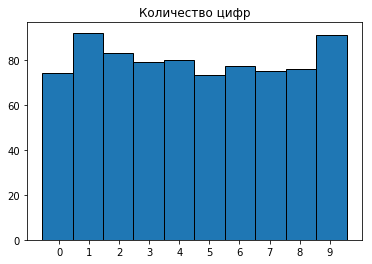

Статистика критерия хи-квадрат: 5.125
p-value:  0.823
Гипотеза не отвергается.


In [112]:
x = np.array([74, 92, 83, 79, 80, 73, 77, 75, 76, 91])

plt.hist(range(10), weights=x, ls='solid', ec='black')
plt.title("Количество цифр")
plt.xticks(np.linspace(0.5, 8.5, 10), range(10))
plt.show()

chisquare_format(sps.chisquare(x))

**Задача (№8 из ДЗ 11 по матстатистике):** Профессиональный дантист научился выбивать зубы мудрости кулаком. Известно, что 52 зуба мудрости он выбил с первой попытки, 31 — со второй, 3 — с третьей, на выбивание оставшихся 5 зубов ему потребовалось более 4 попыток. Проверить гипотезу о том, что дантист выбивает произвольный зуб мудрости с вероятностью 2/3, на уровне значимости 0.05.

Заметим, что такая ситуация соответствует геометрическому распределению. Также объединим категории "выбил с 3 попыток" и "выбил с >= 4 попыток", так как применение критерия хи-квадрат некорректно, если не для каждого $p^0_j$ выполнено $n p^0_j \geq 5$.

In [31]:
x = np.array([52, 31, 8])
chisquare_format(sps.chisquare(x, x.sum() * np.array([2/3, 2/9, 1 - 2/3 - 2/9])))

Статистика критерия хи-квадрат: 7.423
p-value:  0.024
Гипотеза отвергается.
